In [3]:
import pandas as pd 
import numpy as np
from scipy import linalg
from scipy.spatial.distance import pdist
import networkx as nx
import sys
import random
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.metrics import DistanceMetric
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from matplotlib import rcParams, cycler

In [4]:
def norm_and_pca_from_df(df):
    '''
    Function processes the data using Principal component analysis(PCA)
    Args:
        df : Dataframe 
    Returns dataframe containing rincipal component of df
    '''
    
    df_normalized = pd.DataFrame()
    cols = list(df.columns)
    df_normalized[cols] = pd.DataFrame(normalize(MinMaxScaler().fit_transform(df[cols])))
    df_normalized.index = df.index
    
    df_pca = pd.DataFrame(PCA(n_components = 3).fit_transform(df_normalized))
    df_pca.columns = ['P1', 'P2','P3']
    df_pca.index = df.index
    
    return df_normalized, df_pca

##########################################################################################

def calculate_eigen_NJW(df, proximity_measure, sigma, k):
    '''
    Function to get eigenvalues and eigenvectors using equation proposed by NJW algorithm
    Args:
        df: Dataframe
        sigma: local scaling parameter
        proximity_measure = distance measures
        k = number of clusters
    Returns matrices containing adjacency and degree values
    '''
    dimension = df.shape[0]
    
    adjacency_matrix = np.zeros([dimension, dimension])
    
    dist = iter(pdist(df, metric=proximity_measure))

    for i in range(dimension):
        for j in range(i+1, dimension):
            d = np.exp(-1 * next(dist)**2/(2 * sigma ** 2))
            adjacency_matrix[i,j] = d
            adjacency_matrix[j,i] = d
            
    
    degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)
    
    # Normalized laplacian matrix
    d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
    laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)
    
    e, v = np.linalg.eigh(laplacian_matrix_normalized)
    X = v[:, -1*k:]
    
    row_sums = X.sum(axis=1)
    Y = X / row_sums[:, np.newaxis]
            
    return X, Y

###########################################################################################

def calculate_eigen_self_tuning(df, k):
    
    dimension = df.shape[0]
    dist_ = pdist(df)
    pd = np.zeros([dimension, dimension])
    dist = iter(dist_)
    for i in range(dimension):
        for j in range(i+1, dimension):  
            d = next(dist)
            pd[i,j] = d
            pd[j,i] = d
            
    #calculate local sigma
    sigmas = np.zeros(dimension)
    for i in tqdm(range(len(pd))):
        sigmas[i] = sorted(pd[i])[7]
    
    adjacency_matrix = np.zeros([dimension, dimension])
    dist = iter(dist_)
    for i in tqdm(range(dimension)):
        for j in range(i+1, dimension):  
            d = np.exp(-1*next(dist)**2/(sigmas[i]*sigmas[j]))
            adjacency_matrix[i,j] = d
            adjacency_matrix[j,i] = d
            
    degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)
    
    # Normalized laplacian matrix
    d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
    laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)
    
    e, v = np.linalg.eigh(laplacian_matrix_normalized)
    X = v[:, -1*k:]
    
    row_sums = X.sum(axis=1)
    Y = X / row_sums[:, np.newaxis]
            
    return X, Y

############################################################################################

def cluster_plots(df_pca_labelled, data, algorithm, k):
    
    if algorithm == OPTICS:
        df_pca_labelled['cluster'] = algorithm(min_samples=k).fit_predict(data)
        
    else:
        df_pca_labelled['cluster'] = algorithm(n_clusters=k).fit_predict(data)
    
    rcParams['figure.figsize']= 12,4

    plt.subplot(1,3,1)
    plot1a = sns.scatterplot(data=df_pca_labelled, x="P1", y="P2", hue="class_label", palette="tab10", s=80, legend=False)
    plot1a.set_title('class labels')

    plt.subplot(1,3,2)
    plot1b = sns.scatterplot(data=df_pca_labelled, x="P1", y="P2", hue="cluster", palette="tab10", s=80, legend=False)
    plot1b.set_title('cluster labels')

    matrix = confusion_matrix(df_pca_labelled.class_label, df_pca_labelled.cluster)
    plt.subplot(1,3,3)
    plot2 = sns.heatmap(matrix, annot=True, cmap="tab10")
    plot2.set(xlabel='Clustering Label', ylabel='Class Label')

    plt.tight_layout()

In [6]:
## Load combined dataset
df_csv = pd.read_csv("dataset_3/d3_mp.csv", index_col=0)
df_csv_data = df_csv.iloc[:, 0:170]

df_normalized, df_pca = norm_and_pca_from_df(df_csv_data)

df_pca['class_label'] = ['N' if 'N' in index
                         else 'H' if 'H' in index
                         else 'CD' if 'CD' in index 
                         else 'IBS' if 'IBS' in  index
                         else 'UCr' if 'UCr' in index 
                         else 'UCa' if 'UCa' in index
                         else 'GCA' if 'GCA' in index 
                         else 'A' if '_A' in index else 'C' 
                         for index, patient in df_pca.iterrows()]

df_pca['class_label'] = df_pca['class_label'].astype('category').cat.codes
df_pca_control = df_pca[['P1','P2']]

C:\Users\49171\AppData\Local\Temp\ipykernel_13592\2126596537.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(MinMaxScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_13592\2126596537.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(MinMaxScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_13592\2126596537.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usual

### Experimental Results

C:\Users\49171\AppData\Local\Temp\ipykernel_13592\2126596537.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.exp(-1 * next(dist)**2/(2 * sigma ** 2))
C:\Users\49171\AppData\Local\Temp\ipykernel_13592\2126596537.py:55: RuntimeWarning: invalid value encountered in divide
  Y = X / row_sums[:, np.newaxis]


3.0 0.5300336892432684 1.0 0.7348515477709086


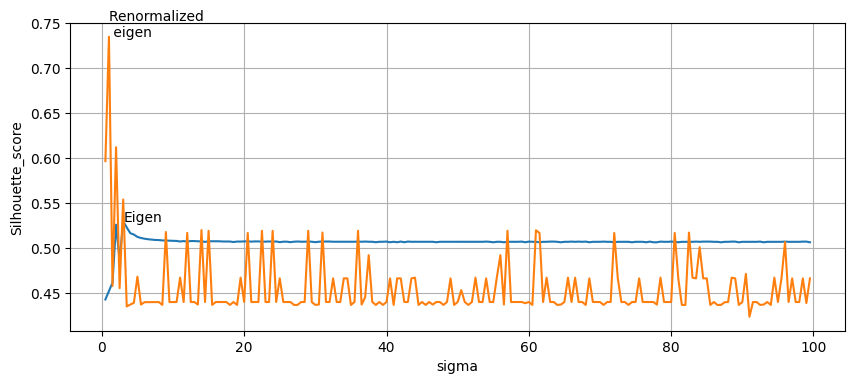

In [13]:
## Find optimal sigma for optimal silhouette

sigma_vals = []
rand_vals1 = []
rand_vals2 = []

for sigma in np.arange(0,100,0.5):
    
    try:
        X,Y = calculate_eigen_NJW(df_pca_control,'euclidean', sigma, 9)
        
        clustering1 = KMeans(n_clusters = 9)
        clustering1.fit(X)
        clustering2 = KMeans(n_clusters = 9)
        clustering2.fit(Y)

        sigma_vals.append(sigma)
        rand_vals1.append(silhouette_score(X, clustering1.labels_))
        rand_vals2.append(silhouette_score(Y, clustering2.labels_))
        
    except:
        pass
    
    
thisdict1 = dict(zip(sigma_vals,rand_vals1))
opt_val1 = max(thisdict1, key = (lambda k: thisdict1[k]))

thisdict2 = dict(zip(sigma_vals,rand_vals2))
opt_val2 = max(thisdict2, key = (lambda k: thisdict2[k]))

print(opt_val1, thisdict1[opt_val1], opt_val2, thisdict2[opt_val2])
    
rcParams['figure.figsize']= 10,4
plt.plot(sigma_vals, rand_vals1)
plt.plot(sigma_vals, rand_vals2)
plt.xlabel('sigma')
plt.ylabel('Silhouette_score')
plt.annotate('Eigen', xy = (opt_val1 + 0.02, thisdict1[opt_val1]))
plt.annotate('Renormalized \n eigen', xy = (opt_val2 + 0.02, thisdict2[opt_val2]))
# plt.title('Normalized eigen (pca data)')
plt.grid()
plt.show()

C:\Users\49171\AppData\Local\Temp\ipykernel_13592\2126596537.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.exp(-1 * next(dist)**2/(2 * sigma ** 2))
C:\Users\49171\AppData\Local\Temp\ipykernel_13592\2126596537.py:55: RuntimeWarning: invalid value encountered in divide
  Y = X / row_sums[:, np.newaxis]


1.5 0.2663015290383206 5.5 0.30277706120501996


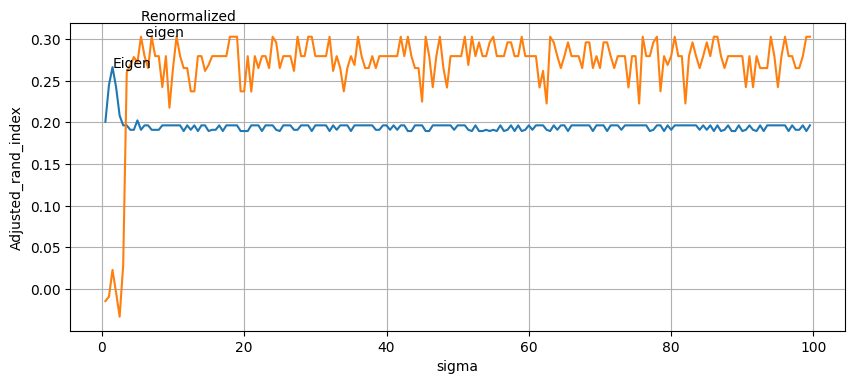

In [15]:
## Find optimal sigma for optimal rand

sigma_vals = []
rand_vals1 = []
rand_vals2 = []

for sigma in np.arange(0,100,0.5):
    
    try:
        X,Y = calculate_eigen_NJW(df_pca_control,'euclidean', sigma, 9)
        
        clustering1 = KMeans(n_clusters = 9)
        clustering1.fit(X)
        clustering2 = KMeans(n_clusters = 9)
        clustering2.fit(Y)

        sigma_vals.append(sigma)
        rand_vals1.append(adjusted_rand_score(df_pca.class_label, clustering1.labels_))
        rand_vals2.append(adjusted_rand_score(df_pca.class_label, clustering2.labels_))
        
    except:
        pass
    
    
thisdict1 = dict(zip(sigma_vals,rand_vals1))
opt_val1 = max(thisdict1, key = (lambda k: thisdict1[k]))

thisdict2 = dict(zip(sigma_vals,rand_vals2))
opt_val2 = max(thisdict2, key = (lambda k: thisdict2[k]))

print(opt_val1, thisdict1[opt_val1], opt_val2, thisdict2[opt_val2])
    
rcParams['figure.figsize']= 10,4
plt.plot(sigma_vals, rand_vals1)
plt.plot(sigma_vals, rand_vals2)
plt.xlabel('sigma')
plt.ylabel('Adjusted_rand_index')
plt.annotate('Eigen', xy = (opt_val1 + 0.02, thisdict1[opt_val1]))
plt.annotate('Renormalized \n eigen', xy = (opt_val2 + 0.02, thisdict2[opt_val2]))
# plt.title('Normalized eigen (pca data)')
plt.grid()
plt.show()

In [18]:
X,Y = calculate_eigen_self_tuning(df_pca_control, 9)
df_U = pd.DataFrame(X)
df_N = pd.DataFrame(Y)

100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 1865.64it/s]


 Unnorm. eigen (optimal value, highest silhouette): (9, 0.551392553476112)
 Unnorm. eigen (optimal value, highest adjusted rand): (9, 0.1785578171156977)


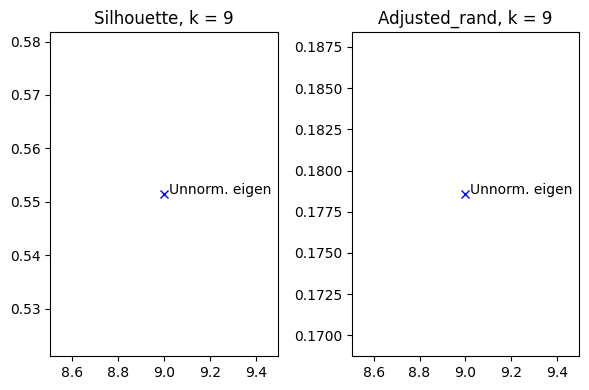

In [19]:
range_param = [9]
algorithms = [KMeans, SpectralClustering, AgglomerativeClustering]
df_csv_data.name = 'Original \n data'
df_normalized.name = 'Normalized'
df_pca_control.name = 'PCA'
df_U.name = 'Unnorm. eigen'
df_N.name = 'Norm. eigen'

list_df = [df_U]

rcParams['figure.figsize']= 6,4

random.seed(10)

plt.subplot(1,2,1)
for df in list_df:
    
    df_temp = df
    
    silhouette_values = []
        
    for value in range_param:
        clustering = KMeans(n_clusters = value)
        # df['cluster']  = clustering.fit_predict(U)
        clustering.fit(df)
        cluster_labels = clustering.labels_  
        silhouette_values.append(silhouette_score(df, cluster_labels))

    thisdict = dict(zip(range_param,silhouette_values))
    opt_val = max(thisdict, key = (lambda k: thisdict[k]))
    print(f' {df.name} (optimal value, highest silhouette): {opt_val, thisdict[opt_val]}')
    plt.plot(range_param,silhouette_values,'-bx')
    plt.annotate(f'{df.name}', xy = (opt_val + 0.02, thisdict[opt_val]))
    plt.title(f'Silhouette, k = {range_param[0]}')
    
    
plt.subplot(1,2,2)
for df in list_df:
    
    df_temp = df
    
    adjusted_rand_values = []
        
    for value in range_param:
        clustering = KMeans(n_clusters = value)
        # df['cluster']  = clustering.fit_predict(U)
        clustering.fit(df)
        cluster_labels = clustering.labels_  
        adjusted_rand_values.append(adjusted_rand_score(df_pca.class_label, cluster_labels))

    thisdict = dict(zip(range_param,adjusted_rand_values))
    opt_val = max(thisdict, key = (lambda k: thisdict[k]))
    print(f' {df.name} (optimal value, highest adjusted rand): {opt_val, thisdict[opt_val]}')
    plt.plot(range_param,adjusted_rand_values,'-bx')
    plt.annotate(f'{df.name}', xy = (opt_val + 0.02, thisdict[opt_val]))
    plt.title(f'Adjusted_rand, k = {range_param[0]}')
    
plt.tight_layout()
plt.show()

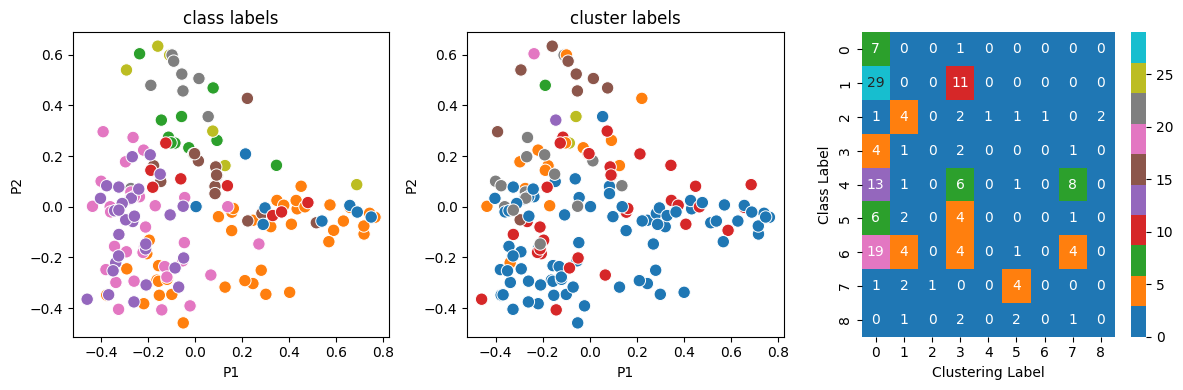

In [4]:
cluster_plots(df_pca, df_csv_data, KMeans, 9)